In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

In [2]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
#Step 1 - Collect data
#Now generate the training data, 
#the input is basically a random binary vector. The output will be the 
#“echo” of the input, shifted echo_step steps to the right.

#Notice the reshaping of the data into a matrix with batch_size rows. 
#Neural networks are trained by approximating the gradient of loss function 
#with respect to the neuron-weights, by looking at only a small subset of the data, 
#also known as a mini-batch.The reshaping takes the whole dataset and puts it into 
#a matrix, that later will be sliced up into these mini-batches.

def generateData():
    #0,1, 50K samples, 50% chance each chosen
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    #shift 3 steps to the left
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

data = generateData()

print(data)

(array([[0, 1, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1]]), array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]]))


In [4]:
#Schematic of the reshaped data-matrix, arrow curves shows adjacent time-steps that ended up on different rows. 
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [5]:

#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#Step 2 - Build the Model

#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [7]:

#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [8]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [9]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unpack columns
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
inputs_series = tf.unpack(batchX_placeholder, axis=1)
labels_series = tf.unpack(batchY_placeholder, axis=1)

In [10]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.

In [11]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat(1, [current_input, current_state])  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state

In [12]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

In [13]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [14]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.801171
Step 100 Loss 0.690763
Step 200 Loss 0.689025
Step 300 Loss 0.689154
Step 400 Loss 0.717302
Step 500 Loss 0.694943
Step 600 Loss 0.689133
New data, epoch 1
Step 0 Loss 0.706546
Step 100 Loss 0.67453
Step 200 Loss 0.624096
Step 300 Loss 0.128657
Step 400 Loss 0.0335549
Step 500 Loss 0.0151251
Step 600 Loss 0.00941374
New data, epoch 2
Step 0 Loss 0.179457
Step 100 Loss 0.00662257
Step 200 Loss 0.00757718
Step 300 Loss 0.00887308
Step 400 Loss 0.0049233
Step 500 Loss 0.00584269
Step 600 Loss 0.00257517
New data, epoch 3
Step 0 Loss 0.138243
Step 100 Loss 0.00288311
Step 200 Loss 0.00215102
Step 300 Loss 0.00295708
Step 400 Loss 0.00223666
Step 500 Loss 0.00159917
Step 600 Loss 0.00210598
New data, epoch 4
Step 0 Loss 0.332048
Step 100 Loss 0.00189445
Step 200 Loss 0.00206697
Step 300 Loss 0.00144389
Step 400 Loss 0.00131734
Step 500 Loss 0.00295013
Step 600 Loss 0.00166442
New data, epoch 5
Step 0 Loss 0.265869
Step 100 Loss 0.00153125
Step 200 Loss

Step 300 Loss 0.000116633
Step 400 Loss 0.00011841
Step 500 Loss 0.000104516
Step 600 Loss 8.26308e-05
New data, epoch 43
Step 0 Loss 0.145613
Step 100 Loss 0.000176441
Step 200 Loss 0.000152155
Step 300 Loss 0.000147032
Step 400 Loss 0.000104812
Step 500 Loss 0.000105963
Step 600 Loss 8.64369e-05
New data, epoch 44
Step 0 Loss 0.139797
Step 100 Loss 0.000135035
Step 200 Loss 0.000189686
Step 300 Loss 0.00011001
Step 400 Loss 0.000141553
Step 500 Loss 9.657e-05
Step 600 Loss 8.99945e-05
New data, epoch 45
Step 0 Loss 0.272629
Step 100 Loss 0.000149893
Step 200 Loss 0.000164461
Step 300 Loss 0.000115544
Step 400 Loss 0.000153854
Step 500 Loss 0.000109407
Step 600 Loss 0.000122863
New data, epoch 46
Step 0 Loss 0.199157
Step 100 Loss 0.000161837
Step 200 Loss 0.000106895
Step 300 Loss 0.000172402
Step 400 Loss 0.000131317
Step 500 Loss 0.00013843
Step 600 Loss 0.000111232
New data, epoch 47
Step 0 Loss 0.210758
Step 100 Loss 0.000122601
Step 200 Loss 0.000156737
Step 300 Loss 0.000121424

Step 400 Loss 8.9673e-05
Step 500 Loss 8.07144e-05
Step 600 Loss 7.77079e-05
New data, epoch 85
Step 0 Loss 0.140473
Step 100 Loss 6.81437e-05
Step 200 Loss 7.75481e-05
Step 300 Loss 6.94606e-05
Step 400 Loss 5.69198e-05
Step 500 Loss 7.27515e-05
Step 600 Loss 8.17882e-05
New data, epoch 86
Step 0 Loss 0.163537
Step 100 Loss 6.48816e-05
Step 200 Loss 5.10073e-05
Step 300 Loss 6.58064e-05
Step 400 Loss 6.56169e-05
Step 500 Loss 6.43313e-05
Step 600 Loss 6.79565e-05
New data, epoch 87
Step 0 Loss 0.150202
Step 100 Loss 7.68893e-05
Step 200 Loss 6.4209e-05
Step 300 Loss 5.24503e-05
Step 400 Loss 8.57617e-05
Step 500 Loss 8.23361e-05
Step 600 Loss 6.51973e-05
New data, epoch 88
Step 0 Loss 0.111673
Step 100 Loss 6.71682e-05
Step 200 Loss 9.552e-05
Step 300 Loss 7.49804e-05
Step 400 Loss 0.000111454
Step 500 Loss 7.88482e-05
Step 600 Loss 4.57156e-05
New data, epoch 89
Step 0 Loss 0.28129
Step 100 Loss 5.2086e-05
Step 200 Loss 5.31334e-05
Step 300 Loss 0.000121431
Step 400 Loss 6.19699e-05


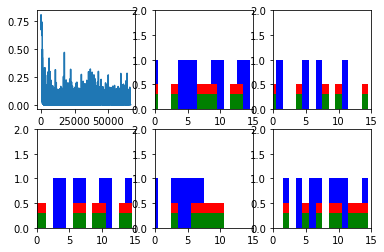

In [15]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()